
# 06. Global atmospheric temperature trends

## Analysing large data sets in MATLAB/octave

<div style='text-align: right'>By Edward Sternin, 2023-10</div>

This simple demo of octave-based data plotting is based on the publicly-available data from UAH (University of Alabama, Huntsville), as reported by the group of John Christy <christy@atmos.uah.edu>. The raw satellite data (NOAA series of satellites; AQUA, starting in mid-2002) from the National Space Science and Technology Centre (http://vortex.nsstc.uah.edu/) is extensively verified and corrected for calibration errors, as those are detected. For example, camera drift as NOAA-18 and NOAA-19 satellites aged was discovered and corrected in 2017, as described <a href="https://www.nsstc.uah.edu/climate/2019/march2019/GTR_201903Mar_1.pdf" target="_blank">here</a>.
 This is the best large-scale atmospheric temperature data that we (the humans) have, free of any bias that may (or may not) exist in the surface-measured temperatures.

In [1]:
### this sets the Jupyter working directory
%cd ~/5P10

In [2]:
### this sets the Octave working directory and search path
cd ~/5P10
addpath("~/5P10")

The following only needs to be done once, using either method below. Rather than read the external data files directly, we first make local copies using the operating system command <code>wget</code> or <code>urlwrite(external_URL,local_file_name)</code>:

In [3]:
### retrieval of files across the network could be deferred to the operating system
### the advantage is that the files will only be downloaded if they changed at the source
system('wget -Nq https://www.nsstc.uah.edu/data/msu/v6.0/tls/uahncdc_ls_6.0.txt');
system('wget -Nq https://www.nsstc.uah.edu/data/msu/v6.0/tmt/uahncdc_mt_6.0.txt');
system('wget -Nq https://www.nsstc.uah.edu/data/msu/v6.0/tlt/uahncdc_lt_6.0.txt');
system('wget -Nq http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt');
system('wget -Nq https://solarscience.msfc.nasa.gov/greenwch/sunspot_area.txt');

In [ ]:
### this is a pure octave call, and will download every time, even if there was no change
urlwrite('https://www.nsstc.uah.edu/data/msu/v6.0/tls/uahncdc_ls_6.0.txt','uahncdc_ls_6.0.txt');
urlwrite('https://www.nsstc.uah.edu/data/msu/v6.0/tmt/uahncdc_mt_6.0.txt','uahncdc_mt_6.0.txt');
urlwrite('https://www.nsstc.uah.edu/data/msu/v6.0/tlt/uahncdc_lt_6.0.txt','uahncdc_lt_6.0.txt');

# Sunspot count data from WDC-SILSO, Royal Observatory of Belgium, Brussels
# column format: year, month, decimal year, SNvalue , SNerror, Nb observations
# monthly averages. The file has no header.
urlwrite('http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt','SN_m_tot_V2.0.txt');

# Monthly averages of the daily sunspot areas, x1e-6 of hemisphere. From dave.hathaway@comcast.net
# - first line is the header with column titles 
# - whitespace as separators (default is comma ',') 
urlwrite('https://solarscience.msfc.nasa.gov/greenwch/sunspot_area.txt','sunspot_area.txt');

In [4]:
### only need to do this once
### this signal-processing package contains Savitsky-Golay filter implementation
pkg load signal;
### this is a useful way of keeping all data in one place
pkg load dataframe;
### needed for regression analysis
pkg load statistics;

## Reading the data in

In [5]:
### read in the local file, skipping the first line as a header, to the end, only the first three columns
d = dlmread('uahncdc_ls_6.0.txt','',[1 0 inf 2]);
### make a decimal date out of year + (month-0.5)/12, i.e. place time at mid-month
### v 6.0 data has a nine-line footer in the file, skip that
year = d(1:end-9,1)+(d(1:end-9,2)-0.5)/12;
t_ls = d(1:end-9,3);
### only need the third columns from the other two data files, year and month are the same
d = dlmread('uahncdc_mt_6.0.txt','',[1 0 inf 2]);
t_mt = d(1:end-9,3);
d = dlmread('uahncdc_lt_6.0.txt','',[1 0 inf 2]);
t_lt = d(1:end-9,3);

### sunspot count data goes back many more years, no header, no footer
# column format: year, month, decimal year, SNvalue , SNerror, Nb observations
d = dlmread('SN_m_tot_V2.0.txt','',[0 0 inf 4]);
sc_year = d(:,1)+(d(:,2)-0.5)/12;
sc = sgolayfilt(d(:,4),2,13);

### sunspot area data goes back many more years, one-line header, no footer
d = dlmread('sunspot_area.txt','',[1 0 inf 2]);
sa_year = d(:,1)+(d(:,2)-0.5)/12;
sa = sgolayfilt(d(:,3),2,13);

Notes:
<ul>
    <li>temperature data: read in the first three columns only, skipping the first (header) line, then convert the first two columns (year,month) into a single decimal year value. Also, truncate the tail end of each dataset, to account for a trailing footer made up of nine text lines;</li>
    <li>sunspot count data: there is no header, but the decimal year value is already pre-calculated (in column 3), use it;</li>
    <li>sunspot area data: one-line header, make the decimal year out of year,month;</li>
    <li>sunspot area data is better than mere sunspot count, but it stops in 2016, as the funding ran out :-(</li>
    <li>all sunspot data is noisy, apply Savitsky-Golay second-order 13-point filter.</li> 
</ul>

## Visualizing the data and identifying influencers

The most obvious influencer is the solar input, and a visual inspection confirms that there is a likely correlation between the solar activity and the atmospheric temperatires:


In [6]:
%plot inline -w 900 -h 600

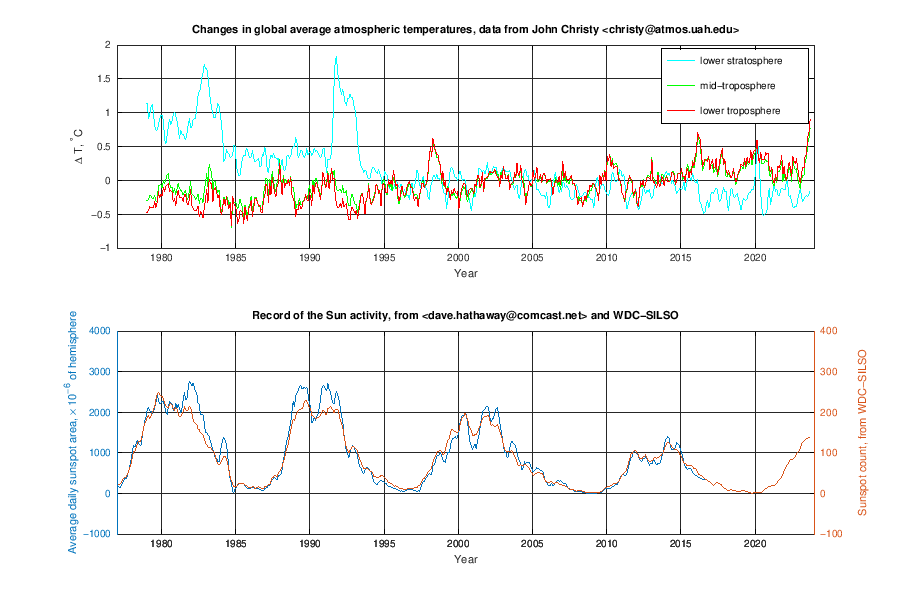

In [7]:
subplot(2,1,1);
plot(year,t_ls,'c-;lower stratosphere;',
     year,t_mt,'g-;mid-troposphere;',
     year,t_lt,'r-;lower troposphere;');
xlim([1977,2024]);
ylabel('\Delta T, ^{\circ}C');
xlabel('Year');
box on;
grid on;
title('Changes in global average atmospheric temperatures, data from John Christy <christy@atmos.uah.edu>');

subplot(2,1,2);
[ax,h1,h2] = plotyy(sa_year,sa,sc_year,sc);
xlim(ax(1),[1977,2024]);
xlim(ax(2),[1977,2024]);
ylabel (ax(1), 'Average daily sunspot area, \times 10^{-6} of hemisphere');
ylabel (ax(2), 'Sunspot count, from WDC-SILSO');
xlabel('Year');
#legend([h1 h2],'sunspot area','sunspot count');
box on;
grid on;
title('Record of the Sun activity, from <dave.hathaway@comcast.net> and WDC-SILSO');

In [8]:
### other useful settings that may come in handy for tweaking the graphs
#set(gcf, 'Position', 0.75*get(0, 'ScreenSize'));
#set(gca, 'FontSize', 15);
#set(legend(),'FontSize', 13);
#set(gcf,'Visible','on');

Clearly, some of the oscillations observed in the temperature data have the same periodicity and are similar in phase to the Sun activity as reported by either of the sun spots data. The next step is to perform some form of regression analysis, to try to remove the effects of this strong influencer.
<p>
However, it is also obvious, especially from the lower stratospheric data, that something else has a dramatic short-term effect on temperature. The two peaks at 1982-93 and 1992-93 stand out. These seem to correspond to the time of two major recent volcaninc eruptions, El Chichon (Mexico, 1982) and Mt. Pinatubo (Phillipines, June 1991). Therefore, full analysis will have to include multiple regressions against both the solar activity and the atmospheric transmission rate which was greatly affected by the volcanic ash emissions.
<p>
Unfortunately, the data for atmospheric transparency is not as extensive, and some missing dates may need to be excluded from consideration. The atmospheric transmission data is derived from the measurements of direct solar radiation at Mauna Loa, Hawaii. The reason why the data measured at a location in Hawaii are very valuable for the global records is because of its remote location from any anthropogenic activities and pollution sources, other land-related events, cross-Atlantic dust storm signatures or continent weather conditions. It is not a perfect global marker; for example, the April 2010 volcanic eruption in Iceland (Eyjafjallajökull) does not seem to affect the Mauna Loa data very strongly, with only a small feature around 2010. Still, it is a good starting point.
<p>
First we download the transparency data and add another graph to the previous plot(s). The transparency decreases due to volcanic eruptions appear to be highly correlated with prominent temperature peaks in the lower statosphere.

In [9]:
system('wget -Nq https://www.esrl.noaa.gov/gmd/webdata/grad/mloapt/mlo_transmission.dat');
### or this:
#urlwrite('https://www.esrl.noaa.gov/gmd/webdata/grad/mloapt/mlo_transmission.dat','mlo_transmission.dat');

In [10]:
### transparency data has a two-line header, no footer
### columns are MMM-YYYY, decimal_year, transparency
# MLO Apparent Transmission Values
# (Morning, monthly means)
# JAN-1958   1958.0416      0.9364
# ...
d = dlmread('mlo_transmission.dat','',[2 0 inf 3]);
tr_year = d(:,2);
tr = d(:,3);

In [11]:
%plot inline -w 900 -h 900

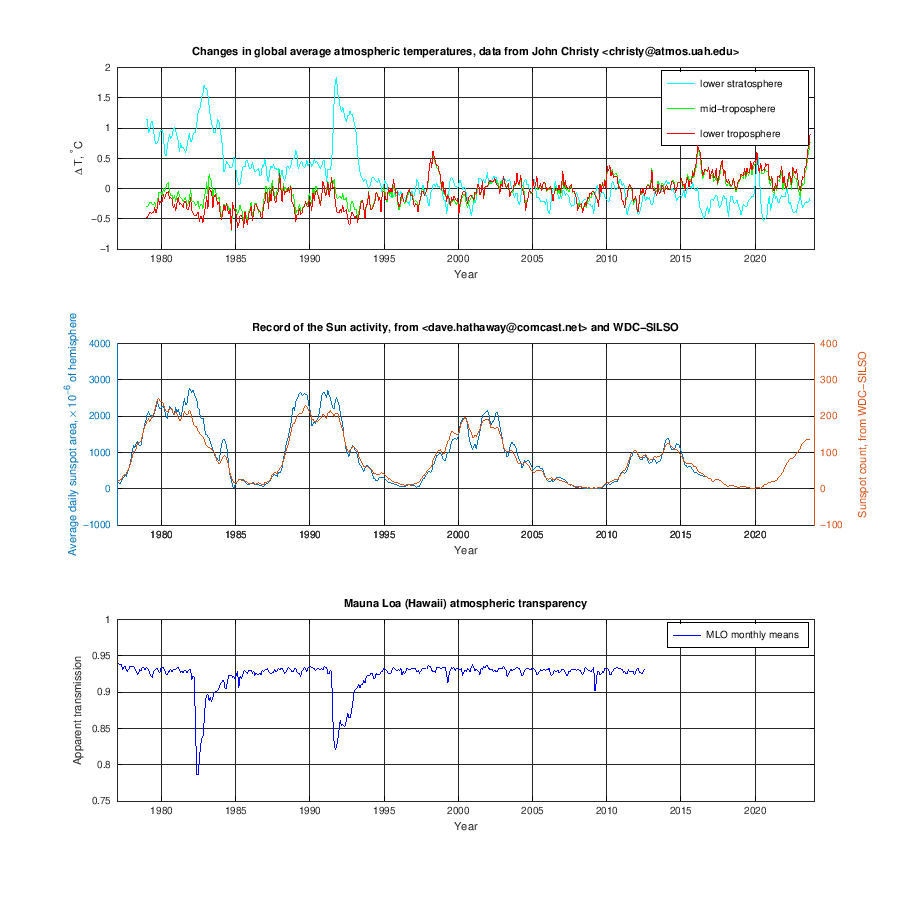

In [12]:
subplot(3,1,1);
plot(year,t_ls,'c-;lower stratosphere;',
     year,t_mt,'g-;mid-troposphere;',
     year,t_lt,'r-;lower troposphere;');
xlim([1977,2024]);
ylabel('\Delta T, ^{\circ}C');
xlabel('Year');
box on;
grid on;
title('Changes in global average atmospheric temperatures, data from John Christy <christy@atmos.uah.edu>');

subplot(3,1,2);
[ax,h1,h2] = plotyy(sa_year,sa,sc_year,sc);
xlim(ax(1),[1977,2024]);
xlim(ax(2),[1977,2024]);
ylabel (ax(1), 'Average daily sunspot area, \times 10^{-6} of hemisphere');
ylabel (ax(2), 'Sunspot count, from WDC-SILSO');
xlabel('Year');
#legend([h1;h2],'sunspot area','sunspot count');
box on;
grid on;
title('Record of the Sun activity, from <dave.hathaway@comcast.net> and WDC-SILSO');

subplot(3,1,3);
plot(tr_year,tr,'b-;MLO monthly means;');
xlim([1977,2024]);
ylabel('Apparent transmission');
xlabel('Year');
box on;
grid on;
title('Mauna Loa (Hawaii) atmospheric transparency');

## Dataframes are useful

Dataframes are objects that offer database or spreadsheet-like properties. After you have all your data gathered into a single dataframe, with descriptive headers, column types (strings, numerical values, etc.) established, and erratic or missing values identified, certain global operations become particularly simple.
<p>
In order to analyze the atmospheric temperature data further and to perform some statistical or other forms of analysis, we blend into a dataframe the data on solar activity from two different sources. Since the data in this case is a time series of measurements we establish a common timebase index for all data.

In [13]:
### give columns meaningfuls names
Columns = ["Year";"T_lowstrato";"T_midtropo";"T_lowtropo";"SunSpotArea";"SunSpotCount";"MLOtransparency"];

### create a dataframe, and append two NaN-filled columns for sunspot data 
zc = NaN(length(year),1);
df = dataframe([year,t_ls,t_mt,t_lt,zc,zc,zc]);
df.colnames = Columns;

### for each temperature data point, find and fill the sunspot values 
for i = 1:length(year)
  df.SunSpotArea(i)=sa( abs(sa_year - year(i)) < 0.01 );
  df.SunSpotCount(i)=sc( abs(sc_year - year(i)) < 0.01 );
  df.MLOtransparency(i)=tr(  abs(tr_year - year(i)) < 0.01 );
endfor

### print out a few lines at the top and bottom of the dataframe
df([1:5,end-5:end],Columns)

ans = dataframe with 11 rows and 7 columns                                           
 _1   Year T_lowstrato T_midtropo T_lowtropo SunSpotArea SunSpotCount MLOtransparency
 Nr double      double     double     double      double       double          double
  1 1979.0     1.14000  -0.300000   -0.48000      1895.3       179.18         0.93380
  2 1979.0     1.14000  -0.300000   -0.48000      2068.2       187.28         0.93270
  3 1979.1     0.92000  -0.280000   -0.44000      2123.4       192.48         0.93150
  4 1979.2     0.98000  -0.220000   -0.39000      2024.8       184.01         0.92580
  5 1979.3     1.09000  -0.230000   -0.41000      2029.6       190.89         0.92200
533 2023.3    -0.28000   0.070000    0.18000         NaN       129.74             NaN
534 2023.4    -0.24000   0.300000    0.37000         NaN       132.70             NaN
535 2023.5    -0.22000   0.320000    0.38000         NaN       134.87             NaN
536 2023.5    -0.24000   0.540000    0.64000         N

## Multi-factor regression analysis

A full regression analysis can calculate the statistical influence of the two major factors, and remove them from the data. Other effects and long-term trends in the data that may be obscured by these major influencers, may then become apparent.  However, it is clear that there could be a time lag between a rise in ash emissions and the associated reduction in the amount of radiation reaching the surface, and any temperature changes in the various layers of the atmosphere. In fact, each of the identified layers may well have its own time delay, different from the others.

In [14]:
%plot inline -w 900 -h 600

ans =

   0.55275
  -0.17207
  -0.26870

ans =

  -0.65813
   0.15691
   0.35029



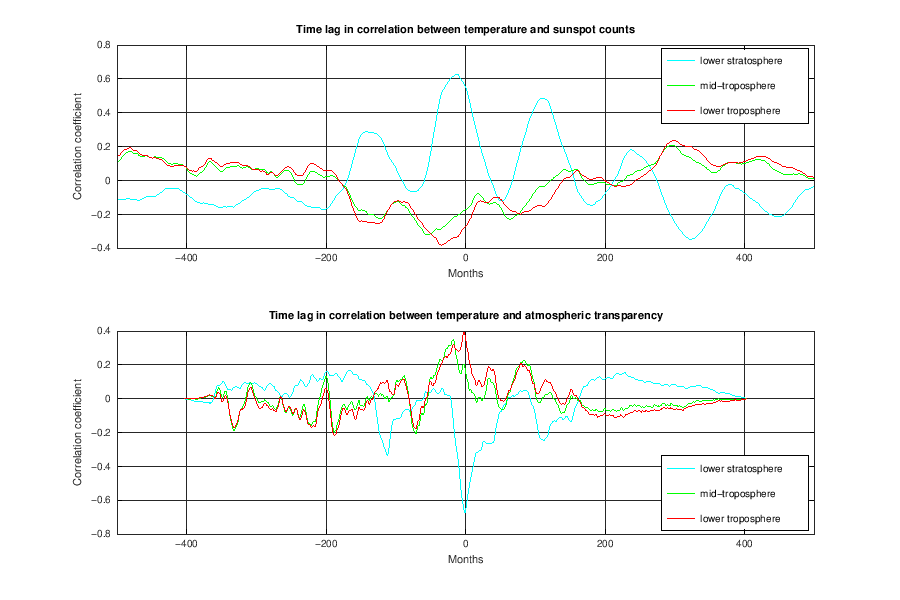

In [15]:
### SunSpot count data is available for all dates
corr([df.T_lowstrato, df.T_midtropo, df.T_lowtropo], df.SunSpotCount)
[R_ls,lag_ls] = xcov(df.SunSpotCount,df.T_lowstrato,'coeff');
[R_mt,lag_mt] = xcov(df.SunSpotCount,df.T_midtropo,'coeff');
[R_lt,lag_lt] = xcov(df.SunSpotCount,df.T_lowtropo,'coeff');

subplot(2,1,1);
plot(lag_ls,R_ls,'c-;lower stratosphere;',
     lag_mt,R_mt,'g-;mid-troposphere;',
     lag_lt,R_lt,'r-;lower troposphere;');
ylabel('Correlation coefficient');
xlabel('Months');
xlim([-500,500]);
box on;
grid on;
title('Time lag in correlation between temperature and sunspot counts');

### transparency is missing some dates, use only the ones that have all data
df1 = df([~isnan(df.MLOtransparency)],Columns);
corr ([df1.T_lowstrato, df1.T_midtropo, df1.T_lowtropo], df1.MLOtransparency)
[RR_ls,llag_ls] = xcov(df1.MLOtransparency,df1.T_lowstrato,'coeff');
[RR_mt,llag_mt] = xcov(df1.MLOtransparency,df1.T_midtropo,'coeff');
[RR_lt,llag_lt] = xcov(df1.MLOtransparency,df1.T_lowtropo,'coeff');

subplot(2,1,2);
plot(llag_ls,RR_ls,'c-;lower stratosphere;',
     llag_mt,RR_mt,'g-;mid-troposphere;',
     llag_lt,RR_lt,'r-;lower troposphere;');
ylabel('Correlation coefficient');
xlabel('Months');
xlim([-500,500]);
legend("location",'southeast');
box on;
grid on;
title('Time lag in correlation between temperature and atmospheric transparency');

## Homework

Complete the multi-factor regression analysis of the data, and plot the temperature data adjusted by subtracting the effects of the two major influencers, level of solar activity and the atmospheric transparency. Be sure to consider and allow for appropriate time lag in the response of the temperature to changes in the influencers. 

In [16]:
%plot inline -w 900 -h 300

shifts =

   12   54   35    1   18    2



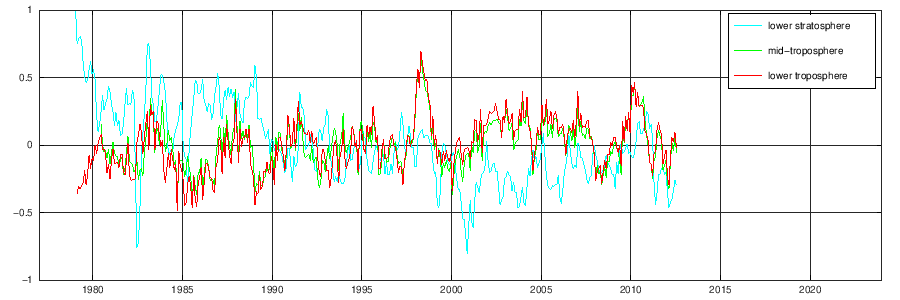

In [17]:
### optimal values of time shifts
[Rmax, i0] = max(abs([R_ls R_mt R_lt]));
[RRmax, i1] = max(abs([RR_ls RR_mt RR_lt]));
shifts = - [ [lag_ls lag_mt lag_lt](i0) [llag_ls llag_mt llag_lt](i1) ]

hold on;

ind = ~isnan(df.MLOtransparency);

x1 = fracshift(df.SunSpotCount,shifts(1));
x2 = fracshift(df.MLOtransparency,shifts(4));
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];
b = regress(df1.T_lowstrato,X);
YY = df1.T_lowstrato - X*b;
plot(df1.Year,YY,'c-;lower stratosphere;');

x1 = fracshift(df.SunSpotCount,shifts(2));
x2 = fracshift(df.MLOtransparency,shifts(5));
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];
b = regress(df1.T_midtropo(ind),X);
YY = df1.T_midtropo - X*b;
plot(df1.Year,YY,'g-;mid-troposphere;');

x1 = fracshift(df.SunSpotCount,shifts(3));
x2 = fracshift(df.MLOtransparency,shifts(6));
X = [ones(size(df1.Year)) x1(ind) x2(ind) ];
b = regress(df1.T_lowtropo,X);
YY = df1.T_lowtropo - X*b;
plot(df1.Year,YY,'r-;lower troposphere;');
xlim([1977,2024]);
box on;
grid on;

hold off;

# Follow-up questions

Evaluate the long-term trends (slope, in $^\circ$C/decade) in the three observed atmospheric zones. Use appropriate statistical methods to evaluate the 95% significance interval ($p<0.05$ for the null hypothesis) for the result.  Does this interval include zero? What does this mean?
<p>
Note the sign of the slope in the linear regression of the atmospheric transparency. What does this imply in terms of the planetary radiative energy balance for Earth?
<p>
Note the size of the regression estimates for the three atmosphetic zones, and compare the strengths of our influencers on the temperature in the three zones. Discuss.